## UCI - Human Activity Recognition Dataset

We will be using this dataset for predicting one out of the 6 activity classes based on the mobile phone sensors data collected for individuals. I have not included the dataset in the repository, but it can be easily downloaded either from [Kaggle](https://www.kaggle.com/datasets/erenaktas/human-activity-recognition) or by running the second cell.

In [6]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import preprocessing, model_selection, metrics, impute, compose, decomposition, neighbors, svm, ensemble, tree, manifold, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

If you wish not to download the dataset manually from web, you can alternatively run the following cell to get data. You might need to do a few manual setup including moving files to correct locations, getting your kaggle API Key etc.

In [ ]:
def download_extract_kaggle_dataset(dataset: str, root_path: str = '.'):
    """
    Download and extract a Kaggle dataset into a 'data' directory in the project root.
    
    Args:
    dataset (str): Kaggle dataset path.
    root_path (str): Root path of the project.
    """
    # Define the download path and extraction path
    download_path = os.path.join(root_path, 'data')
    if not os.path.exists(download_path):
        os.makedirs(download_path)

    # Initialize API
    api = KaggleApi()
    api.authenticate()

    # Download dataset
    api.dataset_download_files(dataset, path=download_path, unzip=False)

    # Extract dataset
    zip_file_path = os.path.join(download_path, dataset.split('/')[-1] + '.zip')
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(download_path)

    # Optionally, remove the zip file after extraction
    os.remove(zip_file_path)

# Example usage
download_extract_kaggle_dataset('erenaktas/human-activity-recognition', 'data/')

The data is clean, already split into training and test set, and it has been normalized between 0 and 1. The description of data and features can be found in ``data/README.md``. Our features are sensor outputs, e.g., acceleration from accelerometer etc. And the goal for this notebook is to predict activity being performed by the user. 
Since it is a popular open dataset, clean and ready to use, there will not be much of data preparation or feature engineering unlike usual projects.

In [3]:
with open('data/features.txt', 'r') as f:
    features = list(map(str.strip, f.readlines()))

train_dataset = pd.read_csv('data/train/X_train.txt', delim_whitespace=True, names=features)
test_dataset = pd.read_csv('data/test/X_test.txt', delim_whitespace=True, names=features)
y_train = pd.read_csv('data/train/y_train.txt', delim_whitespace=True, names=['label'])
y_test = pd.read_csv('data/test/y_test.txt', delim_whitespace=True, names=['label'])

In [4]:
pd.concat([y_train.tail(3), train_dataset.tail(3)], axis=1)

,label,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
7349,2,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,2,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339
7351,2,0.351503,-0.012423,-0.203867,-0.269270,-0.087212,0.177404,-0.377404,-0.038678,0.229430,...,-0.058402,-0.387052,-0.740738,-0.280088,-0.007739,-0.056088,-0.616956,-0.783267,0.246809,0.036695


The 6 classes are as follows:

In [15]:
with open('data/activity_labels.txt', 'r') as f:
    labels = list(map(str.strip, f))

labels

['1 WALKING',
 '2 WALKING_UPSTAIRS',
 '3 WALKING_DOWNSTAIRS',
 '4 SITTING',
 '5 STANDING',
 '6 LAYING']

And as we can see below, the dataset is not one of the most balanced ones - "laying" class has around 1.5 times more samples than "walking downstairs" class.

In [8]:
y_train.value_counts()

label
6        1407
5        1374
4        1286
1        1226
2        1073
3         986
Name: count, dtype: int64

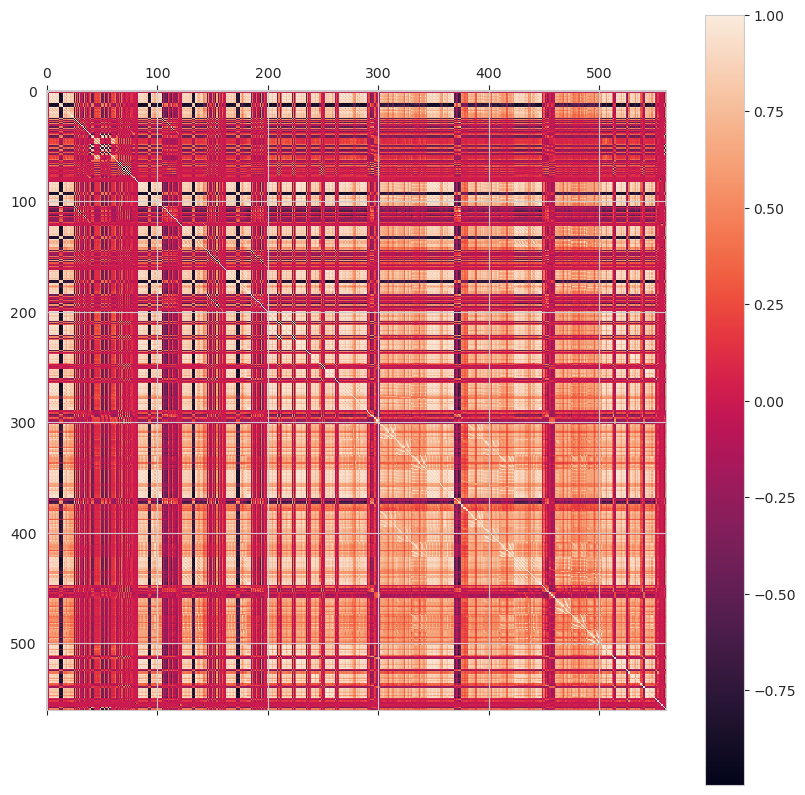

<Figure size 640x480 with 0 Axes>

In [44]:
# Create a figure with a specific size
fig, ax = plt.subplots(figsize=(10,10))

cax = ax.matshow(train_dataset.corr(), interpolation='nearest')
fig.colorbar(cax)

plt.show()
plt.savefig('figures/train_corr.jpg')

This correlation matrix reveals interesting info. The wide horizontal red strip at the top means these features are not correlated with other features, and similarly, the following narrow red strips also convey the same for respective features. The other lighter appearing features are highly correlated with each other and there are plenty of them. This makes sense because the dataset's author say the most of the features have been engineered from a smaller set of original features.

What does this mean for us? In this case, we do not want to have that much of collinearity. This will simply be wasting a lot of computational resources. Let us look for the most important features. We will be using the following techniques for getting feature importances:
1. ANOVA and $\eta^2$
2. Decision Tree's ``feature_importances``
3. Principal Component Analysis (PCA)

**1. ANOVA**

In [50]:
def calculate_eta_squared(data: pd.DataFrame, labels: pd.Series) -> pd.DataFrame:
    eta_squared_values = {}

    if isinstance(labels, pd.DataFrame):
        labels = labels.iloc[:, 0]

    for feature in data.columns:
        # Prepare the groups for ANOVA
        groups = [data.loc[labels == label, feature] for label in labels.unique()]
        # Perform ANOVA
        f_statistic, p_value = stats.f_oneway(*groups)
        # Calculate eta-squared using the F-statistic
        eta_squared = f_statistic / (f_statistic + (len(data) - len(labels.unique())))
        eta_squared_values[feature] = eta_squared

    # Sort features by eta-squared values in descending order
    sorted_features = sorted(eta_squared_values.items(), key=lambda item: item[1], reverse=True)
    return sorted_features

In [51]:
sorted_features_by_importance = calculate_eta_squared(train_dataset, y_train)
sorted_features_df = pd.DataFrame(sorted_features_by_importance, columns=['Feature', 'Eta-squared'])

sorted_features_df

,Feature,Eta-squared
0,367 fBodyAccJerk-entropy()-X,0.834042
1,41 tGravityAcc-mean()-X,0.799884
2,53 tGravityAcc-min()-X,0.793195
3,368 fBodyAccJerk-entropy()-Y,0.792848
4,50 tGravityAcc-max()-X,0.784149
...,...,...
556,162 tBodyGyroJerk-mean()-Y,0.000263
557,"556 angle(tBodyAccJerkMean),gravityMean)",0.000189
558,81 tBodyAccJerk-mean()-X,0.000109
559,82 tBodyAccJerk-mean()-Y,0.000085


From the visuals above, it is pretty clear that 282 out of our 561 features have $\eta^2$<0.2, which means that only less than half of the features are able to explain more than 20%  of the variance ratio in target attribute. Let's back our claim with a different technique, using 

**2. Tree Based Feature Importances**

In [64]:
rf = ensemble.RandomForestRegressor(n_estimators=10, max_depth=10, min_samples_leaf=10)
rf.fit(train_dataset, np.array(y_train).ravel())

tree_based_feature_importance = pd.DataFrame({'Feature': features, 'Importance': dt.feature_importances_})

tree_based_feature_importance.sort_values(by='Importance')

,Feature,Importance
0,1 tBodyAcc-mean()-X,0.000000
371,372 fBodyAccJerk-maxInds-Z,0.000000
370,371 fBodyAccJerk-maxInds-Y,0.000000
369,370 fBodyAccJerk-maxInds-X,0.000000
368,369 fBodyAccJerk-entropy()-Z,0.000000
...,...,...
74,"75 tGravityAcc-arCoeff()-Z,2",0.098147
508,509 fBodyAccMag-energy(),0.111611
559,"560 angle(Y,gravityMean)",0.135684
271,272 fBodyAcc-mad()-X,0.205894


In [65]:
rf.score(train_dataset, y_train)

0.9925927020031438

The Random Forest we used shows that 556 out of 561 features are completely useless. This looks unconvincing, and sure it is. The score in the next cell explains it all. Clearly, our RF overfits the data and hence it unreliable to count on these importances. We can go ahead and try to tune the forest, but that is not out concern right now. We are just selecting the most important featuers. Let us finally try

**3. PCA**

In [5]:
pca = decomposition.PCA(n_components=0.99)

compressed_train_dataset = pca.fit_transform(train_dataset)
compressed_train_dataset.shape

(7352, 155)

As we suspected, only 155 out of 561 features are able to explain 99% of the variance in dataset! Hence we have minimized our computational workload to less than half. One last thing before we move on to modelling, let us try and visualize the 6 classes with 

**t-SNE**

In [ ]:
tsne = manifold.TSNE(n_components=2)
tsne_train_dataset = tsne.fit_transform(train_dataset)

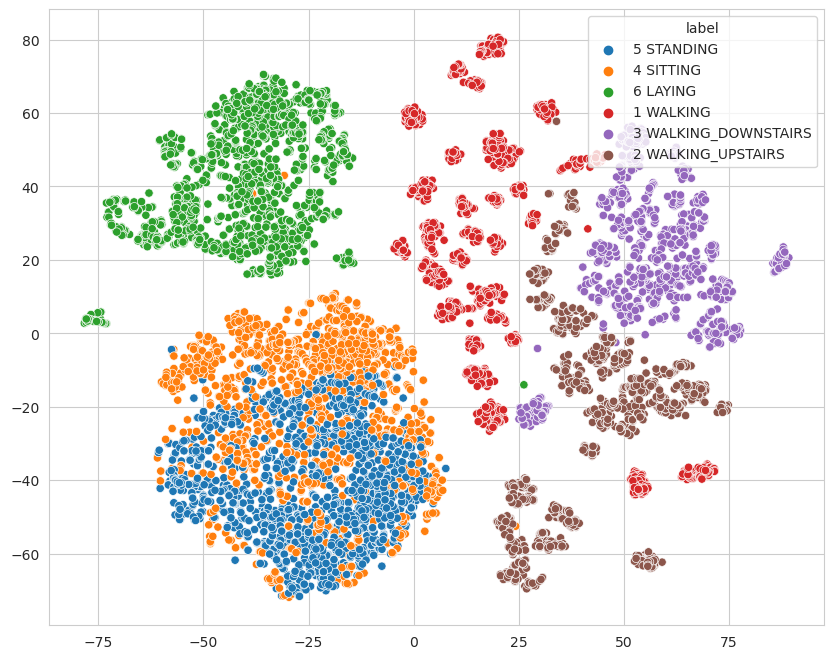

In [117]:
label_dict = {i+1: labels[i] for i in range(len(labels))}
y_train_mapped = y_train.map(label_dict)

plt.figure(figsize=(10,8))
sns.scatterplot(x=tsne_train_dataset[:, 0], y=tsne_train_dataset[:, 1], hue=y_train_mapped)

plt.show()

There are a few crucial insights we could take hold of from this chart. First, classes "sitting" and "standing" are very similar (I trust t-SNE's ability to capture relationships :P), so we know beforehand to tackle these when any of our models that we are going to use confuse between these. Second, it clearly separates movement-classes (walking, walking_upstairs etc) from non-movement-classes (sitting, standing etc); which should be obvious.

**Modelling**
Let's try a few simple models on this first.

In [27]:
svc = svm.SVC()
lr = linear_model.LogisticRegression(solver='sag', multi_class='multinomial')
dt = tree.DecisionTreeClassifier()
rf = ensemble.RandomForestClassifier()

In [15]:
y_train.iloc[:, 0].shape

(7352,)

In [32]:
models = [svc, lr, dt, rf] 

for model in models:
    scores = model_selection.cross_validate(model, compressed_train_dataset, y_train.iloc[:, 0], cv=5, n_jobs=4, scoring='precision_macro', return_train_score=True)

    print(model)
    print("Training Scores:", scores['train_score'].mean())
    print("Validation Scores:", scores['test_score'].mean())

SVC()
Training Scores: 0.9896614576403486
Validation Scores: 0.9414995620929622


/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

LogisticRegression(multi_class='multinomial', solver='sag')
Training Scores: 0.9920308205734483
Validation Scores: 0.9356881668650934
DecisionTreeClassifier()
Training Scores: 1.0
Validation Scores: 0.7707310226625568
RandomForestClassifier()
Training Scores: 1.0
Validation Scores: 0.8927130357958433


So our **SVC** and **Logistic Regression** perform pretty good at both training and validations folds. Also, **Random Forest** seems to overfit a bit with proper tuning we might improve it. However, I am gonna stick with the first two models and tune them (and probably ensemble them later if needed).

In [33]:
params_grid_svc = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                   'kernel': ['rbf'],
                   'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_svc = model_selection.GridSearchCV(estimator=svc, param_grid=params_grid_svc, cv=5, n_jobs=4, scoring='precision_macro', return_train_score=True)

In [34]:
grid_svc.fit(compressed_train_dataset, y_train.iloc[:, 0])

/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

GridSearchCV(cv=5, estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='precision_macro')

In [45]:
pd.DataFrame(grid_svc.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
37,0.095828,0.003238,0.081754,0.001859,1000,0.01,rbf,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",0.933203,0.916550,...,0.944813,0.018525,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
31,0.095649,0.004561,0.079888,0.004623,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.932577,0.915944,...,0.943808,0.017972,2,0.999838,1.000000,1.000000,1.000000,1.000000,0.999968,0.000065
25,0.094962,0.004416,0.090305,0.002636,10,0.01,rbf,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.928044,0.916853,...,0.943684,0.017974,3,0.996686,0.995457,0.996219,0.995914,0.996046,0.996064,0.000400
36,0.108460,0.027344,0.075526,0.019793,1000,0.001,rbf,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",0.926534,0.909802,...,0.940347,0.021297,4,0.997016,0.996271,0.997491,0.996085,0.996693,0.996711,0.000507
30,0.085359,0.001272,0.076135,0.002234,100,0.001,rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.925191,0.906173,...,0.937635,0.020538,5,0.993244,0.991067,0.990712,0.990461,0.991966,0.991490,0.001015
24,0.123669,0.030537,0.153792,0.031462,10,0.001,rbf,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",0.931706,0.898257,...,0.936930,0.021389,6,0.983421,0.980786,0.981805,0.980283,0.983405,0.981940,0.001299
19,0.162678,0.040585,0.197204,0.057586,1,0.01,rbf,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.929193,0.909745,...,0.935892,0.016281,7,0.984736,0.983428,0.984285,0.981798,0.985255,0.983900,0.001210
32,0.598303,0.034265,0.286800,0.018433,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.924510,0.877221,...,0.918041,0.029931,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
26,0.555870,0.021633,0.272886,0.006763,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.924510,0.877221,...,0.918041,0.029931,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
38,0.558729,0.020336,0.274941,0.015437,1000,0.1,rbf,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}",0.924510,0.877221,...,0.918041,0.029931,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


These results show that there is lot of overfitting going on in the best of our parameter combinations. We shall revisit this later, but for now let us move ahead to Logistic Regression.